# This notebook is full of OCC Lab functions created for lab research. 

## Anna's function for polar quiver

In [1]:
subplot_kws = dict(projection=ccrs.SouthPolarStereo())
fig, ax = plt.subplots(figsize=[12, 6],subplot_kw=subplot_kws)
Summer_szn_speed.sel(lat=slice(-90,-55)).plot(cmap=cmocean.cm.speed,
                                     levels=30,
                                     transform =ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()
Summer_szn.isel(lon=slice(None, None, 6),lat=slice(0, 36, 6)).plot.quiver(x='lon',
                                       y='lat',
                                       u='uas',
                                       v='vas',
                                       width=0.003,
                                       scale=100, transform =ccrs.PlateCarree())
plt.title('Summer(DJF) Wind Speed (m/s) around Antarctica')

# You can specify vmin and vmax as ARGUMENTS to your function
# and in your code within your function specify vmin=vmin, vmax=vmax in your .plot() call

NameError: name 'ccrs' is not defined

## James function 1
If anyone is creating an array of plots and you want to add row labels, here is an example of a really easy way to do it.

In [2]:
rows = ['Ensemble 1', 'Ensemble 2', 'Ensemble 3', 'Ensemble 4','Ensemble Mean']
for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(-10, 80), 
                xycoords='axes points', ha='center', va='center', color='k', rotation=90, fontsize=12)
# The zip function creates a pack of tuples, meaning it iterates through whatever you put in for (x, y) 
    #in pairs. So it simultaneously iterates through the axes and the rows which are predefined.

NameError: name 'ax' is not defined

## James function 2

In [3]:
def detrend(da, variable_name):
    '''Alternative function for dedrifting without momlevel or numpy's polyfit.
    
    Takes:
    
    1) DataArray (NOT a DataSet) and 
    
    2) The name of the variable you are dedrifting, given as a string (i.e., 'ssh', 'zos', 'so', etc...).
    The variable name is used to name new arrays explicitly.
    
    Returns a DataSet with arrays containing slope, intercept, trendline and the new dedrifted DataArray.
    '''
    # Check if xarray has a time dimension
    if 'time' not in da.dims:
        raise ValueError("DataArray must have 'time' dimension")
    
    # Reminder to provide variable name for convenient renaming or array
    if type(variable_name) is not str:
        raise TypeError(f'String expected as Variable_name, instead got {type(variable_name).__name__}')

    # Convert time to integers relative to the start (i.e., time[0] == 0) and take mean
    t_values = np.arange(len(da['time']))

    t_mean = t_values.mean()

    # Calculate the mean of data along the time dimension
    da_mean = da.mean(dim='time')

    # Reshape time_values to avoid broadcasting errors
    t_reshaped = xr.DataArray(t_values, dims=['time'])

    # Calculate slope
    slope = ((da - da_mean) * (t_reshaped - t_mean)).sum(dim='time') / ((t_reshaped - t_mean) ** 2).sum()

    # Calculate intercept
    intercept = da_mean - slope * t_mean

    # Calculate the trend
    trend = slope * t_reshaped + intercept

    # Detrend the data by subtracting the trend without subtracting the intercept
    # intercept should not be removed because the data should be centered around initial pressure rather than 0 Pa
    detrended = da - (slope * t_reshaped)
    
    dsout = xr.Dataset()
    dsout[f'{variable_name}_slope'] = slope
    dsout[f'{variable_name}_intercept'] = intercept
    dsout[f'{variable_name}_dedrifted'] = detrended
    dsout[f'{variable_name}_trend'] = trend

    return dsout

#example
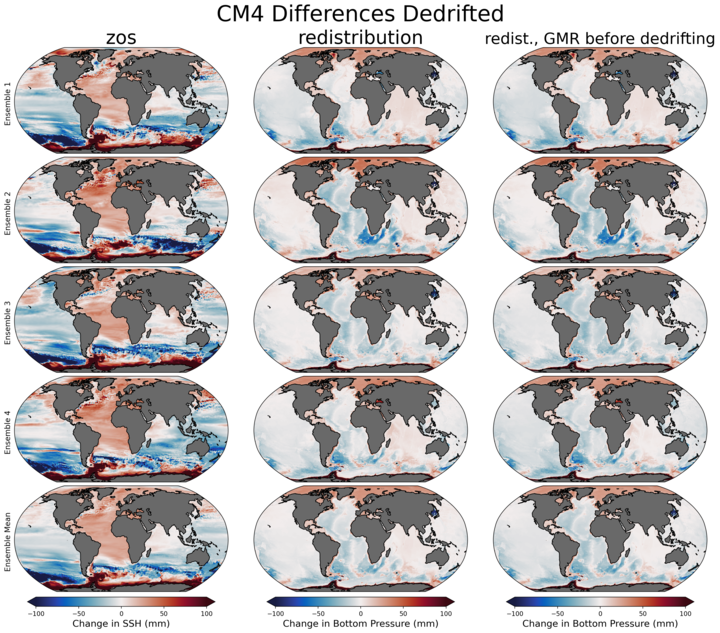


## Will function 1
Adapted code from this forum to create the segmented colorbar seen in tyler's pictures in the katabatics channel.

In [4]:
colors = {
    'Ross': "green", # value=0
    'Filchner': "blue",    # value=1
    'Low East': "yellow",   # value=2
    'Low West': "purple", # value=3
    'Peninsula': "red",    # value=4
    'Plateau': "orange",    # value=5
}

yy, xx = np.mgrid[35:45:1, -120:-110:1]
zz = np.random.randint(0, len(colors), xx.shape)

cmap = mpl.colors.LinearSegmentedColormap.from_list("lcc", list(colors.values()))

bounds = np.arange(len(colors)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


im = ax.pcolormesh(xx, yy, zz, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

NameError: name 'np' is not defined

In [5]:
#Imagine the code for a cartopy projection

In [6]:
cb = fig.colorbar(im, ax=ax, shrink=.5, aspect=8)
cb.set_ticks(bounds[:-1]+0.5)
cb.set_ticklabels(colors.keys())

NameError: name 'fig' is not defined

## James function 3
Here's convenient function for plotting a polar projection that optionally takes a new figsize, max_extent, and facecolor. I'd recommend implenting this so you dont have to start every cell with a whole big thing like you're doing currently. Basic example uses without and with adjusted parameters. If you guys would find it useful to have something else dynamically adjustable, lmk. Also, I don't have any specific errors coded in, but if you pass help(south_pole_map), it will display the docstrings which may be useful.

Updates: It now takes rows or columns, and it can also now take both to create a gridded display.
I tested it in several cases and didn't find any bugs. I also fixed a bug with adding colorbars that won't shrink your plots.

In [3]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='gray'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

In [2]:
#EXAMPLE

fig, ax = south_pole_map(cols=4, rows=2, fig_size=(18, 8))

# column 1
cm4_pc_zos_dedrifted.zos_slope.plot(x='geolon', y='geolat', ax=ax[0,0],
                                   cmap=cmocean.cm.balance, vmin=-.5, vmax=.5, transform=ccrs.PlateCarree(), add_colorbar=False,)

p1 = cm4_pc_pbo_dedrifted.pbo_slope.plot(x='geolon', y='geolat', ax=ax[1,0],
                                   cmap=cmocean.cm.balance, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), add_colorbar=False,)

# shared colorbar for column 1. In this case, they shouldn't have the same colorbar bc the scales differ, but its just an example.
p1cb = plt.colorbar(p1, ticks=np.linspace(-10,10,5),
                    shrink=.8, extend='both', orientation='horizontal')
p1cb.set_label(u'Some Label and units (mm yr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})', fontsize=15)

#title for this column
ax[0,0].set_title('Your')

# column 2
cm4_pc_zos_dedrifted.zos_slope.plot(x='geolon', y='geolat', ax=ax[0,1],
                                   cmap=cmocean.cm.balance, vmin=-.5, vmax=.5, transform=ccrs.PlateCarree(), add_colorbar=False,)

p2 = cm4_pc_pbo_dedrifted.pbo_slope.plot(x='geolon', y='geolat', ax=ax[1,1],
                                   cmap=cmocean.cm.balance, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), add_colorbar=False,)
p2cb = plt.colorbar(p2, ticks=np.linspace(-10,10,5),
                    shrink=.8, extend='both', orientation='horizontal')
p2cb.set_label(u'Some Label and units (mm yr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})', fontsize=15)

ax[0,1].set_title('Titles')

# column 3
cm4_pc_zos_dedrifted.zos_slope.plot(x='geolon', y='geolat', ax=ax[0,2],
                                   cmap=cmocean.cm.balance, vmin=-.5, vmax=.5, transform=ccrs.PlateCarree(), add_colorbar=False,)

p3 = cm4_pc_pbo_dedrifted.pbo_slope.plot(x='geolon', y='geolat', ax=ax[1,2],
                                   cmap=cmocean.cm.balance, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), add_colorbar=False,)

p3cb = plt.colorbar(p3, ticks=np.linspace(-10,10,5),
                    shrink=.8, extend='both', orientation='horizontal')
p3cb.set_label(u'Some Label and units (mm yr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})', fontsize=15)

ax[0,2].set_title('Go')

# column 4
cm4_pc_zos_dedrifted.zos_slope.plot(x='geolon', y='geolat', ax=ax[0,3],
                                   cmap=cmocean.cm.balance, vmin=-.5, vmax=.5, transform=ccrs.PlateCarree(), add_colorbar=False,)

p4 = cm4_pc_pbo_dedrifted.pbo_slope.plot(x='geolon', y='geolat', ax=ax[1,3],
                                   cmap=cmocean.cm.balance, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), add_colorbar=False,)

p4cb = plt.colorbar(p4, ticks=np.linspace(-10,10,5),
                    shrink=.8, extend='both', orientation='horizontal')
p4cb.set_label(u'Some Label and units (mm yr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})', fontsize=15)
ax[0,3].set_title('Here')

fig.suptitle('Testing Gridded Polar Projections', fontsize=35)

rows = ['You can put a row title here', 'And Here!']

for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(-10, 80), 
                xycoords='axes points', ha='center', va='center', color='k', rotation=90, fontsize=12)

NameError: name 'south_pole_map' is not defined

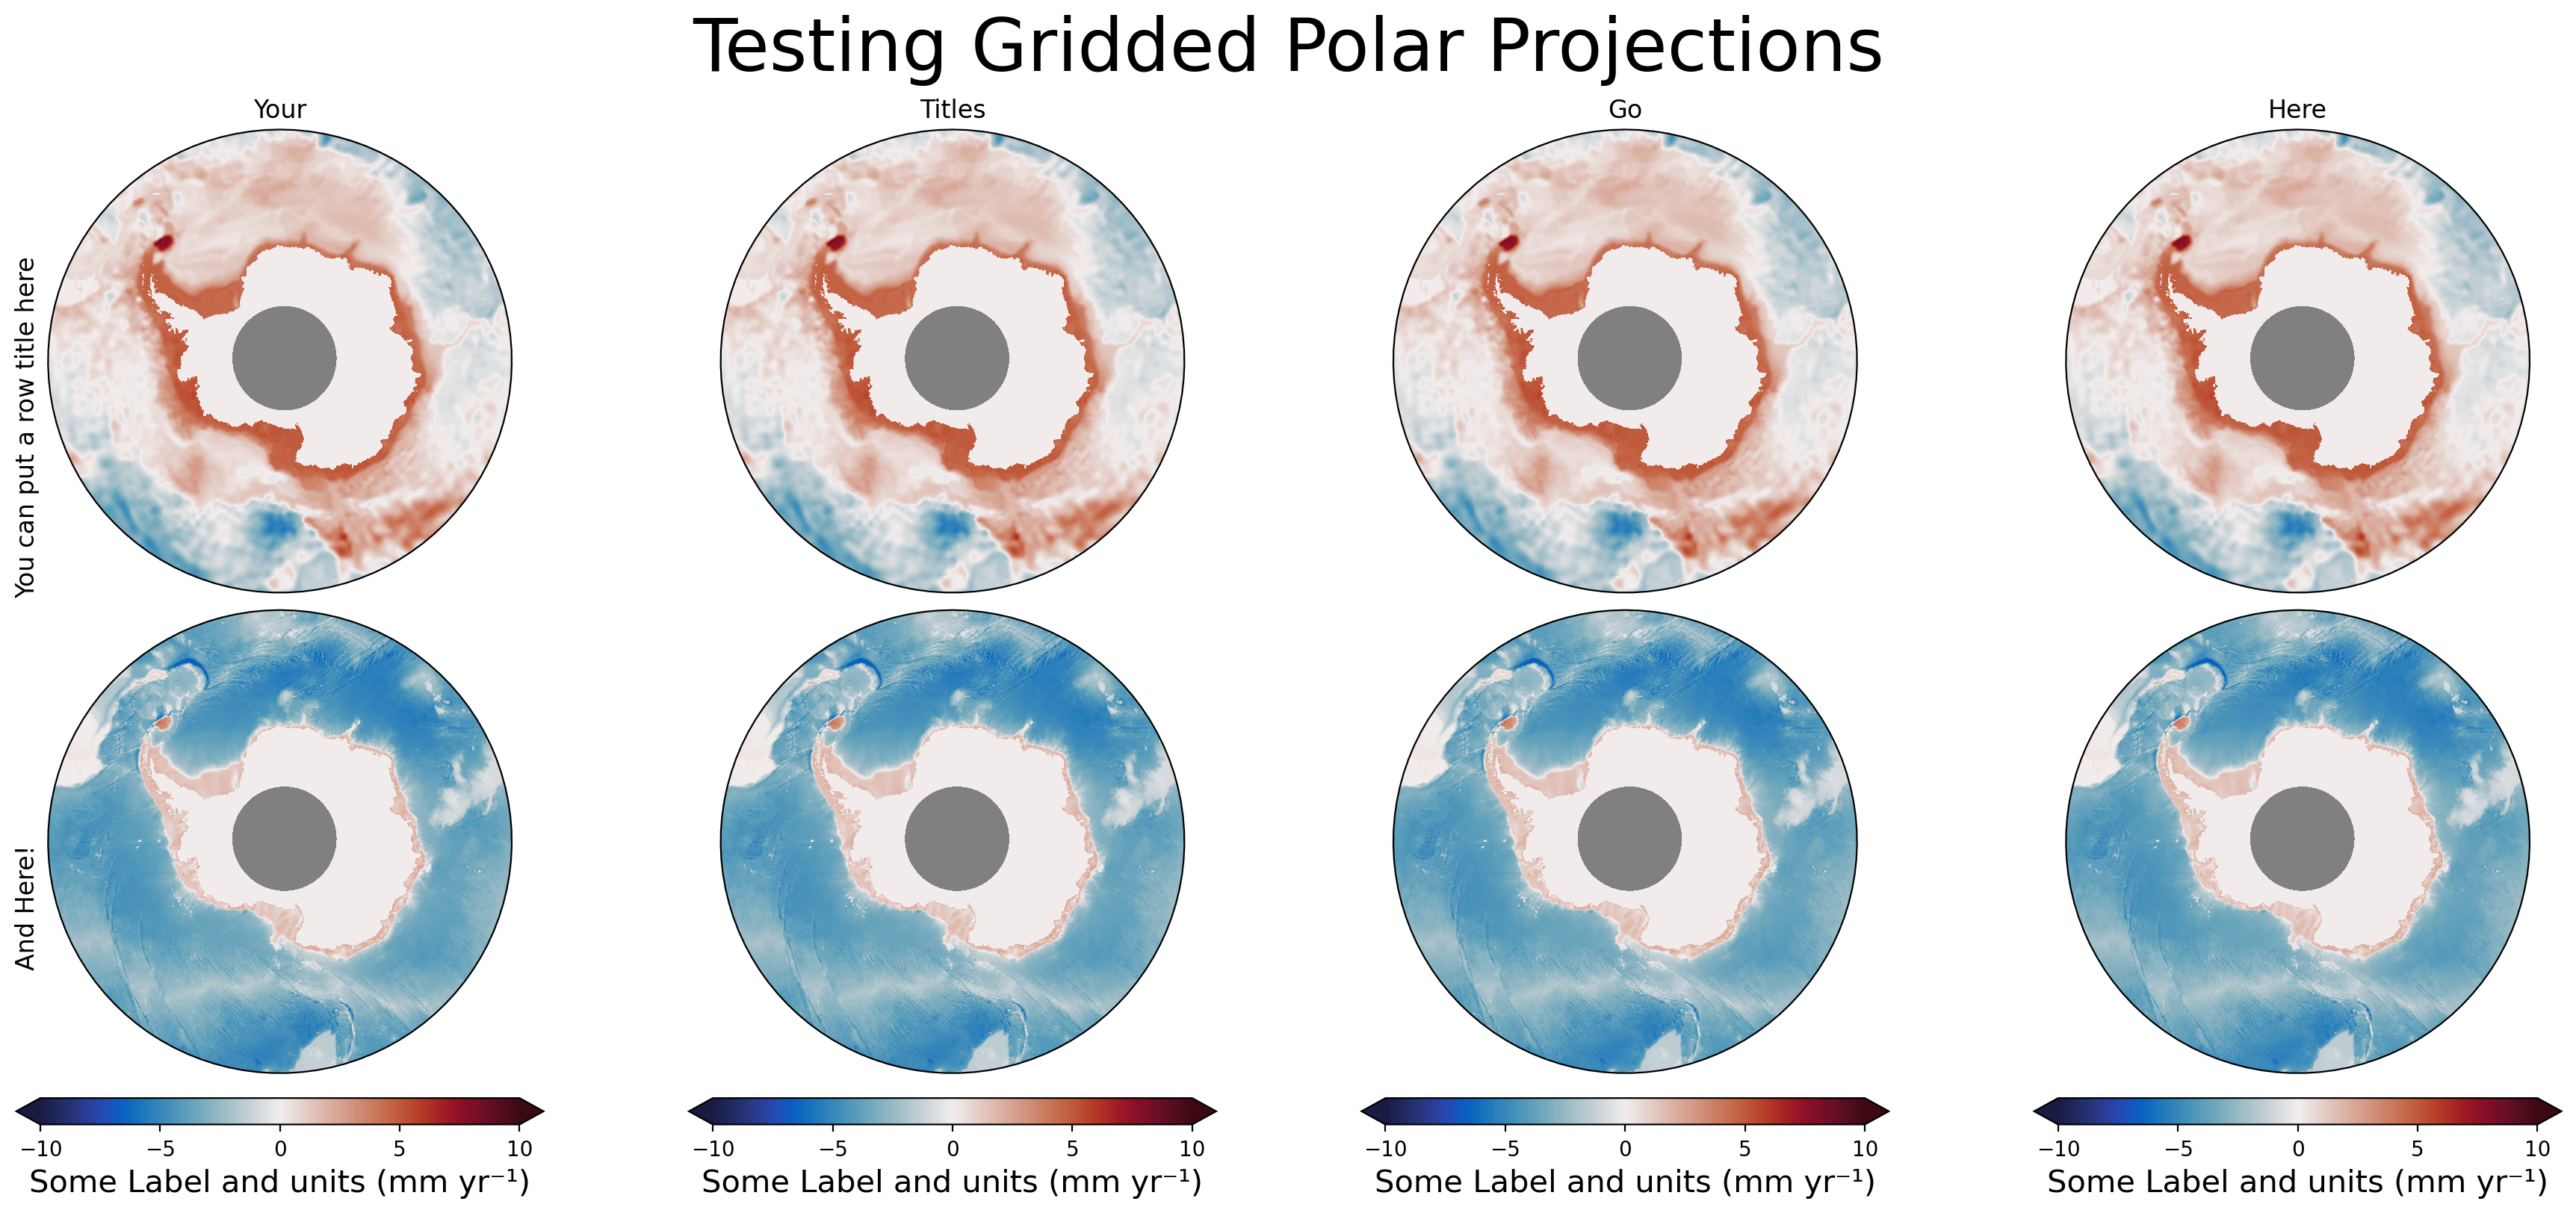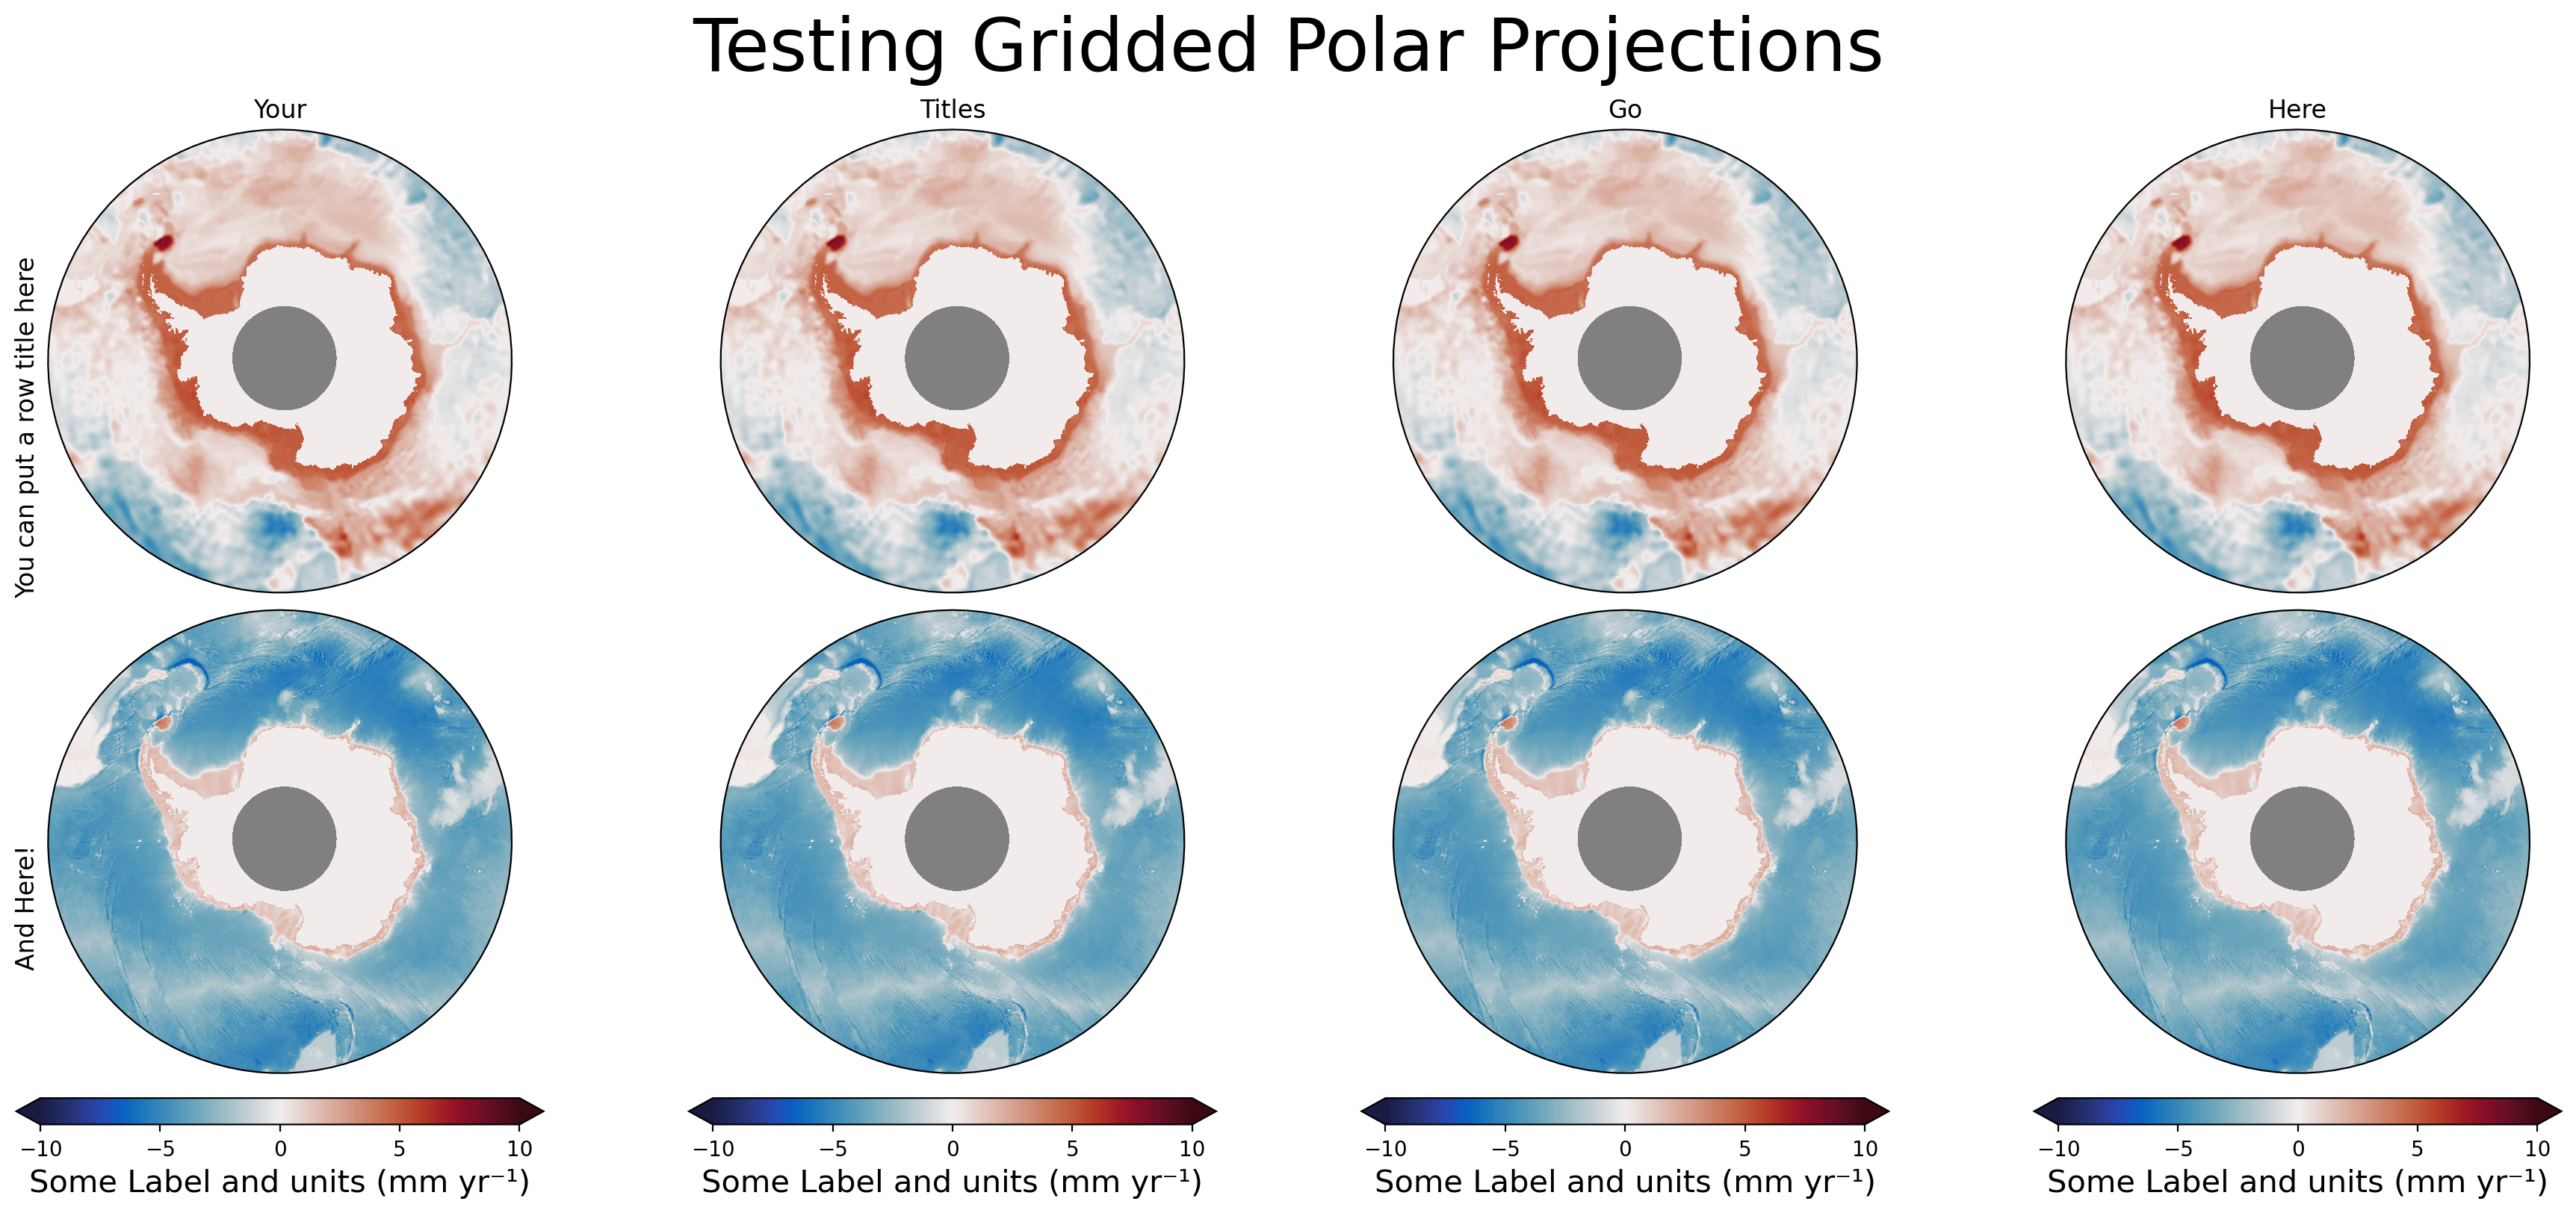

# James function 4
plot on shelf and add a countour

In [1]:
def iso_shelf(variable_arr, colormap, depth_arr, vmin, vmax, plot_bottom=True, bottom_color=cmocean.cm.gray,
              shelf_depth=1000, linewidth=2, linecolor='k', var_x_coord='xh', var_y_coord='yh', depth_x_coord='xh', depth_y_coord='yh'):
    '''
    Isolates an ocean variable overtop the Antarctic continental shelf and plots a contour at the edge.
    
    Requires an Dataarray to plot some ocean variable, vmin and vmax for the ocean Dataarray, the colormap representing the ocean dataarray, and a bathymetric-depth Datarray.
    
    Optionally plots the bathymetry, set to True by default, and does this in 'gray' by default, but this can be adjusted.
    
    By default, shelf depth is set to 1000m, linewidth for the shelf contour is 2, linecolor is black. all x and y coordinates are 'xh' and 'yh' by default, but can be changed to 'geolat' and 'geolon' (or other CS).
    '''
    # if statement plots bathymetry, unless plot_bottom is changed to False
    if plot_bottom:
        depth_arr.plot(x=depth_x_coord, y=depth_y_coord, transform=ccrs.PlateCarree(), add_colorbar=False, cmap=bottom_color)
    
    # selects all values of the chosen array between the ANtarctic coast and the northern boundary of the Drake Passage. Then, plots this only where the depth is less than 1000m, or an alternatviely provided depth
    arr_shelf = variable_arr.sel(yh=slice(-90,-60)).where(depth_arr<=shelf_depth)
    
    arr_shelf.plot(x=var_x_coord, y=var_y_coord,  transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax, cmap=colormap)
    
    # plots a contour line at 1000m, or the supplied depth and takes several optional parameters
    depth_arr.sel(yh = slice(-90,-60)).plot.contour(x=depth_x_coord, y=depth_y_coord,
                                            transform=ccrs.PlateCarree(), add_colorbar=False, 
                                            levels=[shelf_depth], 
                                            colors = linecolor, linewidths = linewidth)

NameError: name 'cmocean' is not defined

# James function 5
These two relabel the x-axis for EW transects or NS transects respectively as their lat/lon. These are actually pretty neat and will probably be useful to everyone at some point. Makes cross sectional plots look nice.

In [2]:
# Define a custom formatter function for East-West Transects
def EW_transect_labels():
    '''
    For a transect going East-West, this labels the x-axis in the format: {LAT}ºE, if 0º or further east, or {LAT}ºW if west of 0º
    '''
    from matplotlib.ticker import FuncFormatter
    def formatter_EWtransect(x, pos):

        from matplotlib.ticker import FuncFormatter
        if x < 0:
            return f'{round(abs(x))}\u00B0W' # negative longitudes will be made positive and labeled as ºW
        else:
            return f'{round(x)}\u00B0E' # positive longitudes and 0 will be labeled with ºE
        
    ax.xaxis.set_major_formatter(FuncFormatter(formatter_EWtransect))
    
# Define a custom formatter function for North-South Transects
def NS_transect_labels():
    '''
    For a transect going North-South, this labels the x-axis in the format: {LAT}ºN, if 0º or further north, or {LAT}ºS if south of 0º
    '''
    from matplotlib.ticker import FuncFormatter
    def formatter_NStransect(x, pos):

        from matplotlib.ticker import FuncFormatter
        if x < 0:
            return f'{round(abs(x))}\u00B0S' # Negative latitudes will be made positive and labeled as ºS
        else:
            return f'{round(x)}\u00B0N' # positive latitudes and 0 will be labeled with ºN
    
    ax.xaxis.set_major_formatter(FuncFormatter(formatter_NStransect))